# OSM Stats Performance Analysis

Analyzing logs and records of OSM Stats from the last 24 hours.

In [1]:
# imports and config
%matplotlib inline

import os
import sys
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# utils for kinesis and lambda
import utils

# OSM stats deployment name
project = 'osmstats-mm'

# name of AWS profile to use
profile = 'osmstats'

# data storage directory
if not os.path.exists(project):
    os.mkdir(project)

## Kinesis stream data

In [2]:
# get data for the last 24 hours from Kinesis

fname = '%s/kinesis_24hr.nljson' % (project)
if not os.path.exists(fname):
    utils.write_nljson(utils.fetch_stream(project, profile=profile), fname)
    os.mknod('%s/kinesis_fetched_%s' % (project, datetime.datetime.now().isoformat()))
    
# read in records
data = utils.read_nljson(fname)

# create DataFrame of record metadata
records = utils.dicts2DataFrame([json.loads(d['Data'])['metadata'] for d in data])
records['timeadded'] = pd.to_datetime([d['ApproximateArrivalTimestamp'] for d in data])
records = records.set_index('timeadded')

There are 3969 records in the Kinesis stream
Data spans 1441 minutes between 2016-04-13 17:19:30.038000 and 2016-04-14 17:19:37.425000
Data gathered during 384 minutes


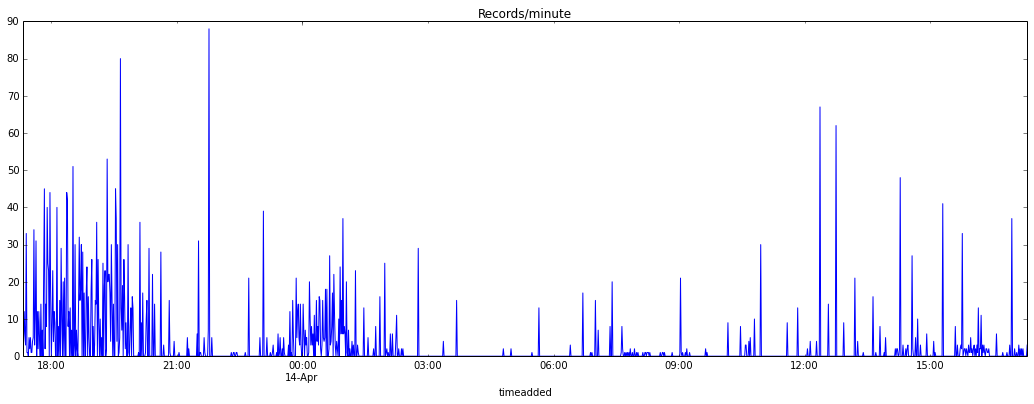

In [3]:
print 'There are %s records in the Kinesis stream' % len(records)

# aggregate to minute
by_minute = records['num_changes'].groupby(pd.TimeGrouper(freq='1Min'))

# print and plot changesets/minute
by_minute_size = by_minute.size()
print 'Data spans %s minutes between %s and %s' % (
    by_minute_size.size, records.index.min(), records.index.max())
print 'Data gathered during %s minutes' % by_minute_size[by_minute_size > 0].size
plt.figure(figsize=(18, 6))
by_minute_size.plot(title='Records/minute')

## Lambda function data

In [5]:
# get logs for the last 24 hours from lambda

# for now, assume this is here, must use branch of awslogs to retrieve
_fname = '%s/lambda_raw_24hr.nljson' % (project)

# then distill these
fname = '%s/lambda_24hr.nljson' % project
if not os.path.exists(fname):
    utils.write_nljson(utils.distill_lambda_logs(_fname).values(), fname)

# read in records
data = utils.read_nljson(fname)

# create records
llogs = utils.dicts2DataFrame(data)

There were 220 lambda requests
of these there were 217 successes and 0 failures (and 3 log fails)
49 requests took longer than 1000 ms
10 requests took longer than 10000 ms


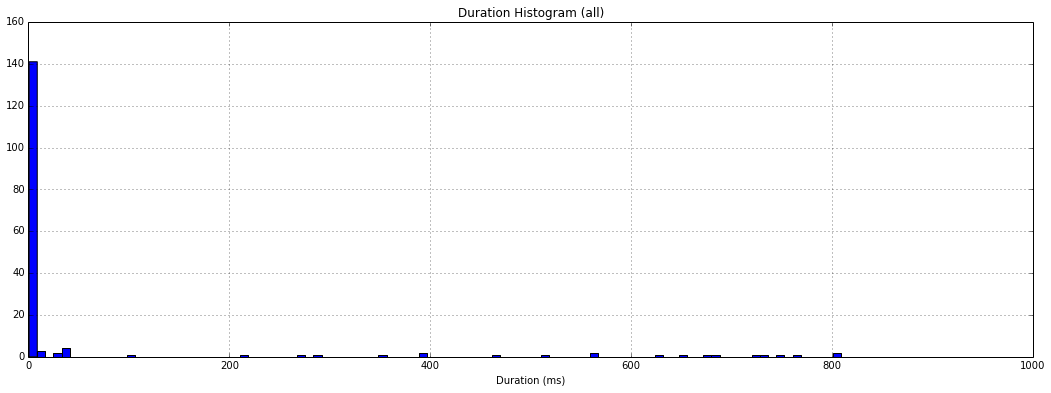

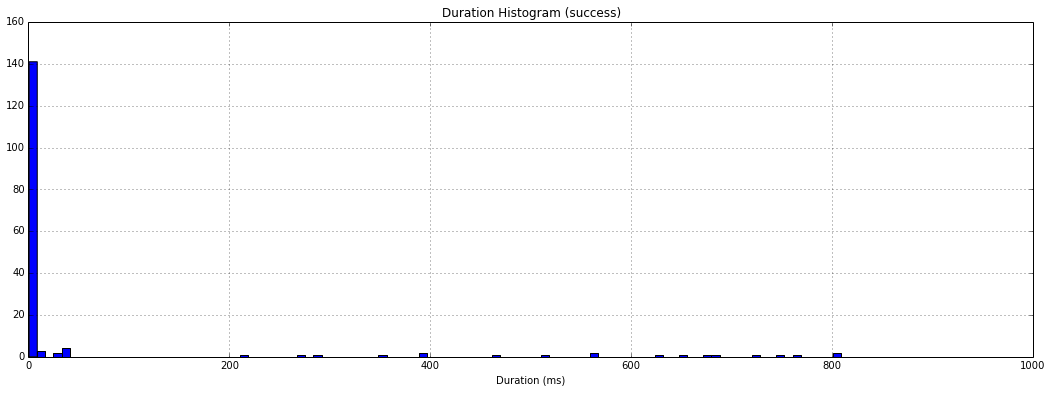

In [6]:
# Plot histograms of durations
print 'There were %s lambda requests' % len(llogs)
successes = llogs['success'].count() if 'success' in llogs else 0
failures = llogs['failure'].count() if 'failure' in llogs else 0
resolved = successes + failures
print 'of these there were %s successes and %s failures (and %s log fails)' % (
    successes, failures, len(llogs) - resolved)

durations = llogs['duration'].astype('float')
cutoff = 1000
duration_cut = durations[durations < cutoff]
print '%s requests took longer than %s ms' % (len(llogs) - len(duration_cut), cutoff)
print '%s requests took longer than %s ms' % (len(llogs) - len(durations[durations < 10000]), 10000)

# plot histograms of durations
plt.figure(figsize=(18,6))
plt.title('Duration Histogram (all)')
plt.xlabel('Duration (ms)')
plt.xlim(0, cutoff)
duration_cut.hist(bins=100)

if successes > 0:
    plt.figure(figsize=(18,6))
    plt.title('Duration Histogram (success)')
    plt.xlabel('Duration (ms)')
    plt.xlim(0, cutoff)
    durations[llogs['success'].notnull() & (durations < cutoff)].hist(bins=100)

if failures > 0:
    plt.figure(figsize=(18,6))
    plt.title('Duration Histogram (failure)')
    plt.xlabel('Duration (ms)')
    plt.xlim(0, cutoff)
    durations[logs['failure'].notnull()& (durations < cutoff)].hist(bins=100)

In [7]:
# examine sizes of payload
payloads = llogs.payload.apply(lambda x: sys.getsizeof(x)/1024.)

print 'Payload Sizes'
print 'Mean = %s KB' % payloads.mean()
print 'Min = %s KB' % payloads.min()
print 'Max = %s KB' % payloads.max()

Payload Sizes
Mean = 0.2734375 KB
Min = 0.2734375 KB
Max = 0.2734375 KB
